In [1]:
from utils import get_image_paths, measure_biofilm, extract_stats
from pathlib import Path
import os

In [2]:
# Define the directory containing your files
before_sonication_path = Path("./data/cropped/before_sonication_std/")
after_sonication_path = Path("./data/cropped/after_sonication_std/")

# Define the output folder path for the generated predictions
output_prediction_before = Path("./output/predictions/before_sonication_std")
output_prediction_after = Path("./output/predictions/after_sonication_std")

# Use the function to get the image paths
before_cropped_images = get_image_paths(before_sonication_path)
after_cropped_images = get_image_paths(after_sonication_path)

# Check if the output folders exist, create it if not
try:
    os.makedirs(output_prediction_before)
    print(f"Output folder created: {output_prediction_before}")
    os.makedirs(output_prediction_after)
    print(f"Output folder created: {output_prediction_after}")
except FileExistsError:
    print(f"Output folder already exists: {output_prediction_before}")
    print(f"Output folder already exists: {output_prediction_after}")

Output folder already exists: output\predictions\before_sonication_std
Output folder already exists: output\predictions\after_sonication_std


In [3]:
# Analyze the images and store the predictions
biofilm_areas_before = measure_biofilm(before_cropped_images, output_prediction_before)
biofilm_areas_after = measure_biofilm(after_cropped_images, output_prediction_after)

# Extract the stats
merged_df = extract_stats(biofilm_areas_before, biofilm_areas_after)

Filename: c_plate10_before, Background: 3267139.0 pixels, Biofilm: 1109751.0 pixels, Plate: 4376890.0
Filename: c_plate11_before, Background: 4120463.0 pixels, Biofilm: 246234.0 pixels, Plate: 4366697.0
Filename: c_plate12_before, Background: 3734441.0 pixels, Biofilm: 640743.0 pixels, Plate: 4375184.0
Filename: c_plate13_before, Background: 3853473.0 pixels, Biofilm: 511760.0 pixels, Plate: 4365233.0
Filename: c_plate14_before, Background: 3180710.0 pixels, Biofilm: 1187912.0 pixels, Plate: 4368622.0
Filename: c_plate15_before, Background: 3739527.0 pixels, Biofilm: 627562.0 pixels, Plate: 4367089.0
Filename: c_plate16_before, Background: 3996181.0 pixels, Biofilm: 367116.0 pixels, Plate: 4363297.0
Filename: c_plate17_before, Background: 3239101.0 pixels, Biofilm: 1129938.0 pixels, Plate: 4369039.0
Filename: c_plate18_before, Background: 4265721.0 pixels, Biofilm: 97607.0 pixels, Plate: 4363328.0
Filename: c_plate19_before, Background: 3874754.0 pixels, Biofilm: 491778.0 pixels, Plate

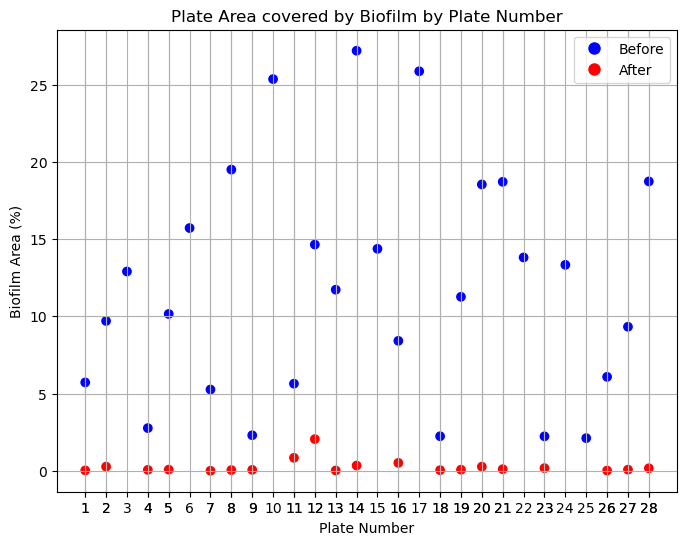

In [4]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(8, 6))
colors = {'before': 'blue', 'after': 'red'} # Assuming 'after' could be a condition as well
plt.scatter(merged_df['plate_nr'], merged_df['biofilm_perc'], c=merged_df['condition'].map(colors), label=['before', 'after'])

plt.title('Plate Area covered by Biofilm by Plate Number')
plt.xlabel('Plate Number')
plt.ylabel('Biofilm Area (%)')
plt.xticks(merged_df['plate_nr']) # Ensure all plate numbers are shown

# Create a legend for conditions
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Before'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='After')])

plt.grid(True)
plt.show()